## Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. 

## Step 1: Load the dataset

The dataset we'll use is the 20newsgroup dataset that is available from sklearn. This dataset has news articles grouped into 20 news categories

In [6]:
from gem.DBLP.DBLP import DBLP
import gensim
from gensim.models.doc2vec import TaggedDocument
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel

from gensim.corpora.dictionary import Dictionary

dblp = DBLP(1000, 1, 1, 3, True)
articles = dblp.read_and_filter_dataset(filterAbstract=False)
dblp.__prepare_external_graph__(articles)
docs = []
indexes = []
articles = [article['abstract'] for article in articles]

[DBLP-Pipeline] Checking if stopwords for nltk package are downloaded
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/grzegorz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[DBLP-Pipeline] NLTK stopwords downloaded
[DBLP-Pipeline] Reading articles from file
[DBLP-Pipeline] Initial: Remove articles with few edges
[DBLP-Pipeline] Reading articles from file has finished. Filtering articles without abstract
[DBLP-Pipeline] Filtered articles without abstract. Tokenizing and removing stop words from abstract
[DBLP-Pipeline] Finding most frequent authors
[DBLP-Pipeline] Filtering articles not containing top authors
[DBLP-Pipeline] Removing non-existing artciles from quoted-by filed in articles
[DBLP-Pipeline] Merging abstract content with title and authors
[DBLP-Pipeline] Remove articles with few edges
[DBLP-Pipeline] Removing non-existing artciles from quoted-by filed in articles


100%|██████████| 979/979 [00:00<00:00, 670513.33it/s]

[DBLP-Pipeline] Writing an external graph content to file


In [7]:
newsgroups_train = articles

In [8]:
#from sklearn.datasets import fetch_20newsgroups
#newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
#newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

### As you can see that there are some distinct themes in the news categories like sports, religion, science, technology, politics etc.

## Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [9]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/grzegorz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [11]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [12]:
import pandas as pd
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [13]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
            #result.append(lemmatize_stemming(token))
            
    return result



In [14]:
'''
Preview a document after preprocessing
'''
document_num = 50
doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'failed', 'times', 'like', 'replaced']


Let's now preprocess all the news headlines we have. To do that, we iterate over the list of documents in our training sample

In [15]:
processed_docs = []

for doc in newsgroups_train:
    processed_docs.append(preprocess(" ".join(doc)))

In [16]:
'''
Preview 'processed_docs'
'''
print(processed_docs[:2])

[['paper', 'presents', 'object', 'management', 'facilities', 'designed', 'generation', 'data', 'manager', 'postgres', 'unique', 'invent', 'data', 'model', 'support', 'objects', 'chooses', 'instead', 'extend', 'relational', 'model', 'powerful', 'abstract', 'data', 'typing', 'capability', 'procedures', 'fledged', 'data', 'base', 'objects', 'reasons', 'remain', 'relational', 'model', 'indicated', 'paper', 'postgres', 'relational', 'extensions'], ['popularity', 'knowledge', 'discovery', 'data', 'mining', 'practice', 'academic', 'corporate', 'professionals', 'association', 'rule', 'mining', 'receiving', 'increasing', 'attention', 'authors', 'present', 'recent', 'progress', 'achieved', 'mining', 'quantitative', 'association', 'rules', 'causal', 'rules', 'exceptional', 'rules', 'negative', 'association', 'rules', 'association', 'rules', 'multi', 'databases', 'association', 'rules', 'small', 'databases', 'book', 'written', 'researchers', 'professionals', 'students', 'working', 'fields', 'data'

## Step 3: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [17]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [18]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abstract
1 base
2 capability
3 chooses
4 data
5 designed
6 extend
7 extensions
8 facilities
9 fledged
10 generation


** Gensim filter_extremes **

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [19]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

** Gensim doc2bow **

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [20]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [21]:
'''
Preview BOW for our sample preprocessed document
'''
document_num = 10
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 6 ("instead") appears 1 time.
Word 41 ("hard") appears 1 time.
Word 48 ("search") appears 1 time.
Word 108 ("combinatorial") appears 1 time.
Word 152 ("able") appears 1 time.
Word 192 ("advantages") appears 2 time.
Word 193 ("allocation") appears 1 time.
Word 194 ("applied") appears 1 time.
Word 195 ("called") appears 1 time.
Word 196 ("combines") appears 1 time.
Word 197 ("complex") appears 1 time.
Word 198 ("created") appears 1 time.
Word 199 ("developed") appears 1 time.
Word 200 ("efficiency") appears 1 time.
Word 201 ("express") appears 1 time.
Word 202 ("expressed") appears 1 time.
Word 203 ("expressive") appears 2 time.
Word 204 ("highly") appears 2 time.
Word 205 ("human") appears 1 time.
Word 206 ("idea") appears 1 time.
Word 207 ("implemented") appears 1 time.
Word 208 ("improvement") appears 1 time.
Word 209 ("introduced") appears 1 time.
Word 210 ("networks") appears 1 time.
Word 211 ("optimization") appears 1 time.
Word 212 ("paradigm") appears 1 time.
Word 213 ("serv

## Step 4: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

** We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.
* **alpha** and **eta** are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is `1/num_topics`)
    - Alpha is the per document topic distribution.
        * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
        * Low alpha: Every document has a mixture of very few topics

    - Eta is the per topic word distribution.
        * High eta: Each topic has a mixture of most words(topics appear similar to each other).
        * Low eta: Each topic has a mixture of few words.

* ** passes ** is the number of training passes through the corpus. For  example, if the training corpus has 50,000 documents, chunksize is  10,000, passes is 2, then online training is done in 10 updates: 
    * `#1 documents 0-9,999 `
    * `#2 documents 10,000-19,999 `
    * `#3 documents 20,000-29,999 `
    * `#4 documents 30,000-39,999 `
    * `#5 documents 40,000-49,999 `
    * `#6 documents 0-9,999 `
    * `#7 documents 10,000-19,999 `
    * `#8 documents 20,000-29,999 `
    * `#9 documents 30,000-39,999 `
    * `#10 documents 40,000-49,999` 

In [22]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
N=4
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = N, 
                                   id2word = dictionary,                                    
                                   passes = 50,
                                   workers = 8)

In [23]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.033*"test" + 0.021*"memory" + 0.016*"program" + 0.013*"cache" + 0.012*"parallel" + 0.011*"fault" + 0.010*"processors" + 0.010*"faults" + 0.008*"execution" + 0.008*"state"


Topic: 1 
Words: 0.014*"clustering" + 0.013*"method" + 0.009*"tree" + 0.009*"structure" + 0.009*"dimensional" + 0.008*"bounds" + 0.008*"graph" + 0.008*"linear" + 0.008*"relation" + 0.008*"simple"


Topic: 2 
Words: 0.012*"software" + 0.011*"queries" + 0.009*"mining" + 0.008*"users" + 0.008*"distributed" + 0.007*"databases" + 0.007*"object" + 0.007*"language" + 0.007*"control" + 0.006*"processing"


Topic: 3 
Words: 0.019*"network" + 0.014*"networks" + 0.014*"theory" + 0.013*"routing" + 0.011*"agents" + 0.011*"probabilistic" + 0.010*"logic" + 0.010*"semantics" + 0.010*"knowledge" + 0.010*"rules"




In [24]:
Y = []
for idx in range(len(processed_docs)):
    bow_corpus_doc = bow_corpus[idx]
    topics = lda_model.get_document_topics(bow_corpus_doc)
    hot_topic = max(topics, key=lambda x: x[1])[0]
    Y.append(hot_topic)

In [25]:
for idx in range(len(processed_docs))[:200]:
    bow_corpus_doc = bow_corpus[idx]
    topics = lda_model.get_document_topics(bow_corpus_doc)
    hot_topic = max(topics, key=lambda x: x[1])[0]
    #if hot_topic == 2:
    #    print (processed_docs[idx])
    #print (hot_topic)
    


In [26]:
# 0 -> hardware / embedded / neworking 
# 1 -> datamining / machine learning
# 2 -> database / compilers / agnet-systems / software-engineering
# 3 -> game theory, algorithms, 

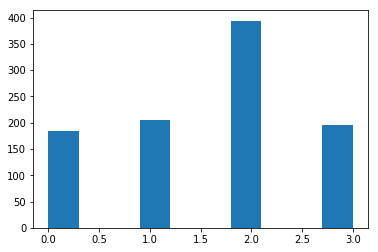

In [27]:
import matplotlib.pyplot as plt
plt.hist(Y)
plt.show()

In [28]:
abstracts = []
abstract_dictionary = []
for article in processed_docs:
    abstracts.append(article)
    abstract_dictionary.append(" ".join(article))

common_dictionary = Dictionary(abstracts)
common_corpus = [common_dictionary.doc2bow(text) for text in abstracts]
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_feature = tfidf_vectorizer.fit_transform(abstract_dictionary)
dataframe = pd.DataFrame(data=tfidf_feature.todense(), columns=tfidf_vectorizer.get_feature_names())
dataframe

,abduction,abide,abiding,abilities,ability,able,abound,abrupt,absence,absent,...,yields,youtube,zadeh,zaiddan,zaniolo,zero,zhang,zone,zones,zwol
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.077618,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.086440,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.094948,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
import umap
import matplotlib.pyplot as plt
np_matrix = dataframe.as_matrix()
np_matrix
np_matrix.shape

(979, 7594)

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE

In [31]:
def plot_embedding(feature_matrix, Y, function_name, title, dict_param):
    if function_name == 'UMAP':
        n_neighbors = dict_param['n_neighbors']
        min_dist = dict_param['min_dist']
        n_components = dict_param['n_components']
        umap_obj = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
        mapped_embedding = umap_obj.fit_transform(feature_matrix)
    elif function_name == 'TSNE':
        tsne_obj = TSNE()
        mapped_embedding = tsne_obj.fit_transform(feature_matrix)
    else:
        print ("unknown embedding method")
        return
   
    colors = ['blue', 'red', 'yellow', 'green']
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    classes = ['hardware/embedded systems/networking', 'data mining/machine learning', 
               'databases/compilers/software engineering', 'game theory/algorithms']
    markers = ['o', 'x', 's', 'P']
    unique = list(set(Y))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [mapped_embedding[:,0][j] for j  in range(len(mapped_embedding)) if Y[j] == u]
        yi = [mapped_embedding[:,1][j] for j  in range(len(mapped_embedding)) if Y[j] == u]
        plt.scatter(xi, yi, c=colors[i], label=classes[i], marker=markers[i])
    plt.title(title)
    plt.legend(loc=4)
    plt.show()
    return mapped_embedding
    

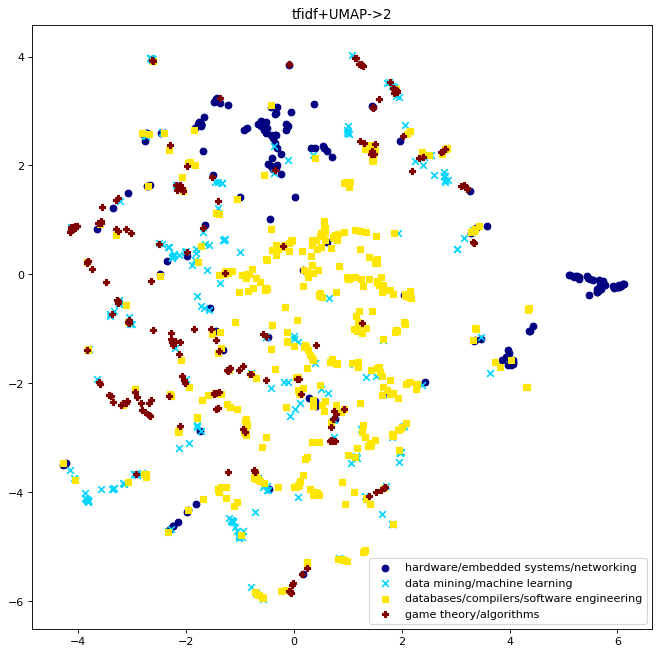

Number of neighbours of the same class metric
k: 1, original dataset 0.7201225740551583 after visualization 0.6557711950970377
Number of common neighbours
k: 1 0.3268641470888662
Number of neighbours of the same class metric
k: 10, original dataset 0.6387129724208366 after visualization 0.5825331971399368
Number of common neighbours
k: 10 0.41419816138917265


In [ ]:
mapped_embedding = plot_embedding(np_matrix, Y, 'UMAP', 'tfidf+UMAP->2', {"n_neighbors": 5, "min_dist": 0.01, "n_components":2})
get_evaluation_metrics(np_matrix, mapped_embedding, Y)
mapped_embedding = plot_embedding(np_matrix, Y, 'TSNE', 'tfidf+TSNE->2', {})
get_evaluation_metrics(np_matrix, mapped_embedding, Y)

In [88]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import itertools
# M to liczba klas
def get_evaluation_metric(X, Y, k):
    unique_classes = list(set(Y))
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)
    total_sum = 0
    M = len(X)
    for idx, element in enumerate(indices):
        sum_of_same_class = 0
        class_of_current_element = Y[idx]
        for el in element[1:]:
            if class_of_current_element == Y[el]:
                sum_of_same_class+=1
        total_sum += (sum_of_same_class / (k-1))
    return total_sum/M

def get_metric_common_neighbours(X_before, X_after, Y, k):
    nbrs_before = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_before)
    nbrs_after = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_after)
    
    _, indices_before = nbrs_before.kneighbors(X_before) 
    _, indices_after = nbrs_after.kneighbors(X_after)
    assert(len(indices_before) == len(indices_after))
    result = 0
    for idx_sample in range(len(indices_before)):
        number_of_common_neighbours = 0
        for el in indices_before[idx_sample][1:]:
            if el in indices_after[idx_sample][1:]:
                number_of_common_neighbours += 1
        result += number_of_common_neighbours
    return result / (len(X_before)*(k-1))
    
def get_evaluation_metric_before_after_vis(X_before, X_after, Y, k):
    return (get_evaluation_metric(X_before, Y, k), get_evaluation_metric(X_after, Y, k))

def get_evaluation_metrics(X_before, X_after, Y):
    for k in [2, 11, 101]:
        value = get_evaluation_metric_before_after_vis(X_before, X_after, Y, k)
        print ("Number of neighbours of the same class metric")
        print ("k: " + str(k-1) + ", original dataset " + str(value[0]) + " after visualization " + str(value[1]))
        print ("Number of common neighbours metric value ")
        print ("k: " + str(k-1) + " " + str(get_metric_common_neighbours(X_before, X_after, Y, k)))
        
#get_metric_common_neighbours(np_matrix, mapped_embedding, Y, 20)



In [65]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
indexes = []
for idx, article in enumerate(articles):
    abstract = article
    docs.append(TaggedDocument(words=abstract, tags=[idx]))

results_doc2vec = []
model = gensim.models.doc2vec.Doc2Vec(vector_size=32, min_count=2, epochs=100)
model.build_vocab(docs)
model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)
for abstract in articles:
    results_doc2vec.append(model.infer_vector(abstract))

In [67]:
np_doc2vec = np.array(results_doc2vec)


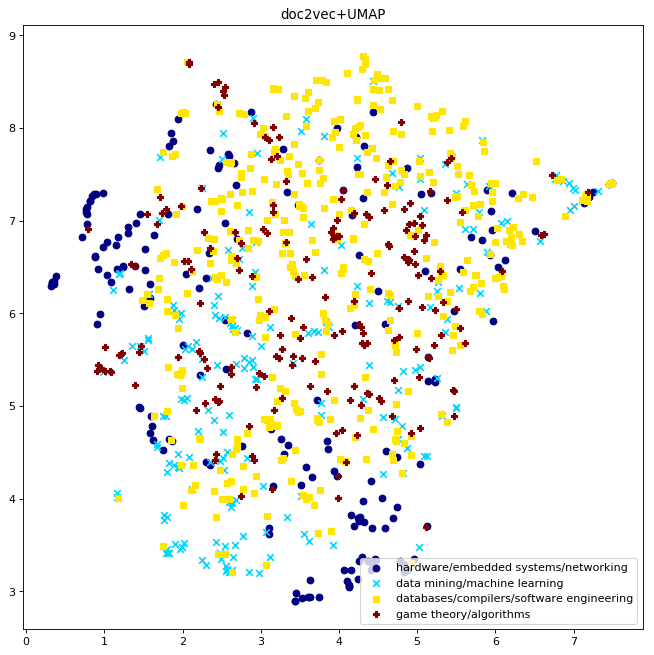

k: 1, original dataset 0.5291113381001021 after visualization 0.5107252298263534
k: 10, original dataset 0.44749744637385075 after visualization 0.4519918283963223
k: 100, original dataset 0.37541368743615916 after visualization 0.3644024514811033


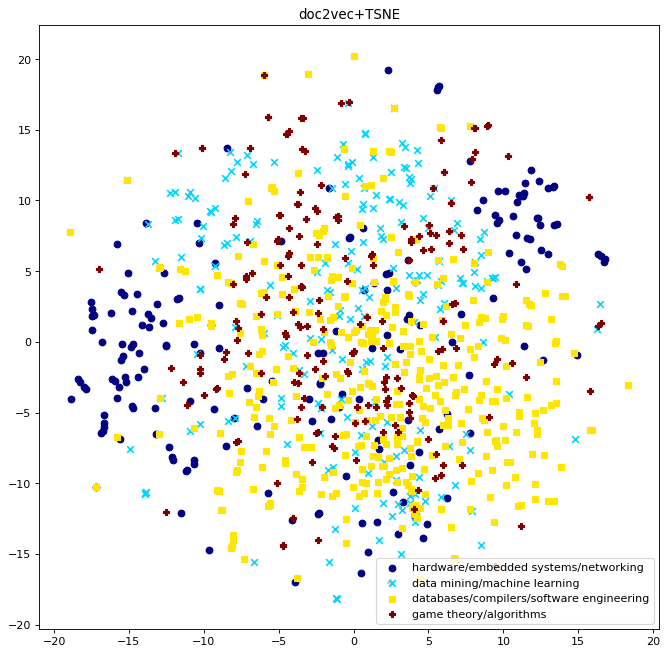

k: 1, original dataset 0.5291113381001021 after visualization 0.5587334014300307
k: 10, original dataset 0.44749744637385075 after visualization 0.47354443309499505
k: 100, original dataset 0.37541368743615916 after visualization 0.36298263534218594


In [70]:
mapped_embedding = plot_embedding(np_doc2vec, Y, 'UMAP', 'doc2vec+UMAP',  {"n_neighbors": 5, "min_dist": 0.01, "n_components":2})
get_evaluation_metrics(np_doc2vec, mapped_embedding, Y)
mapped_embedding = plot_embedding(np_doc2vec, Y, 'TSNE', 'doc2vec+TSNE', {})
get_evaluation_metrics(np_doc2vec, mapped_embedding, Y)

### Classification of the topics ###

Using the words in each topic and their corresponding weights, what categories were you able to infer?

* 0: Graphics Cards
* 1: Religion
* 2: Space
* 3: Politics
* 4: Gun Violence
* 5: Technology
* 6: Sports
* 7: Encryption 

## Step 6: Testing model on unseen document ##

In [ ]:
num = 100
unseen_document = newsgroups_test.data[num]
print(unseen_document)

In [ ]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
print(newsgroups_test.target[num])

The model correctly classifies the unseen document with 'x'% probability to the X category.